#### LangGraph에서 도구(tool) 활용 방법

- 도구(tool)를 활용한 에이전트 개발 방법을 알아봅니다
- workflow를 직접 선언하지 않고, 사용가능한 도구들을 전달하면, 에이전트가 적합한 도구를 판단해서 사용합니다
    - 이번 회차에서는 `ToolNode`를 통해 도구를 활용하는 방법을 알아봅니다

In [18]:
from dotenv import load_dotenv
import os
# .env 파일을 불러와서 환경 변수로 설정
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
print(OPENAI_API_KEY[:2])

UPSTAGE_API_KEY = os.getenv("UPSTAGE_API_KEY")
print(UPSTAGE_API_KEY[30:])

gs
NY


In [19]:
from langchain_upstage import ChatUpstage
llm = ChatUpstage(
        model="solar-pro",
        base_url="https://api.upstage.ai/v1",
        temperature=0.5
    )
print(llm)

client=<openai.resources.chat.completions.completions.Completions object at 0x00000265C1CACBC0> async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x00000265C1C0AAB0> model_name='solar-pro' temperature=0.5 model_kwargs={} upstage_api_key=SecretStr('**********') upstage_api_base='https://api.upstage.ai/v1'


In [20]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a * b

- LangGraph는 `ToolNode`를 통해 도구를 활용합니다
- `ToolNode`의 `invoke()`결과는 도구의 `invoke()` 결과와 유사합니다
    - 도구는 도구의 실행 결과를 리턴하고, `ToolNode`는 도구의 실행 결과를 포함한 `ToolMessage`를 리턴합니다

In [21]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply]
llm_with_tools = llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

print(type(llm_with_tools))
print(tool_node)

<class 'langchain_core.runnables.base.RunnableBinding'>
tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'add': StructuredTool(name='add', description='숫자 a와 b를 더합니다.', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x00000265B177BC40>), 'multiply': StructuredTool(name='multiply', description='숫자 a와 b를 곱합니다.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x00000265B177B9C0>)}, tool_to_state_args={'add': {}, 'multiply': {}}, tool_to_store_arg={'add': None, 'multiply': None}, handle_tool_errors=True, messages_key='messages')


In [22]:
multiply.invoke({'a': 3, 'b': 5})

15

In [23]:
ai_message = llm_with_tools.invoke('What is 3 plus 5?')
ai_message

AIMessage(content="[The 'add' function is ESSENTIAL to compute the sum of 3 and 5, which directly answers the question. No alternative or simpler method exists given the available tools.]", additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-51501fe64cda409ebad35402193c35c5', 'function': {'arguments': '{"a": 3, "b": 5}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 580, 'total_tokens': 637, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'solar-pro2-250909', 'system_fingerprint': None, 'id': '6f8a3c70-7f80-469c-b575-8132be3ed29e', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4fa6cfc2-72f6-4c30-9802-a6246ffe0469-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 5}, 'id': 'chatcmpl-tool-51

In [24]:
ai_message.tool_calls

[{'name': 'add',
  'args': {'a': 3, 'b': 5},
  'id': 'chatcmpl-tool-51501fe64cda409ebad35402193c35c5',
  'type': 'tool_call'}]

- `ToolNode`를 `invoke()`하려면 `tool_calls` 속성을 포함한 `AIMessage`를 전달해야 합니다

In [25]:
tool_node.invoke({'messages': [ai_message]})

{'messages': [ToolMessage(content='8', name='add', tool_call_id='chatcmpl-tool-51501fe64cda409ebad35402193c35c5')]}

- 간단한 에이전트를 만들기 위해 LangGraph에서 제공하는 [`StateGraph`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)를 사용합니다

In [32]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [11]:
def agent(state: MessagesState) -> MessagesState:
    """
    에이전트 함수는 주어진 상태에서 메시지를 가져와
    LLM과 도구를 사용하여 응답 메시지를 생성합니다.

    Args:
        state (MessagesState): 메시지 상태를 포함하는 state.

    Returns:
        MessagesState: 응답 메시지를 포함하는 새로운 state.
    """
    # 상태에서 메시지를 추출합니다.
    messages = state['messages']
    
    # LLM과 도구를 사용하여 메시지를 처리하고 응답을 생성합니다.
    response = llm_with_tools.invoke(messages)
    
    # 응답 메시지를 새로운 상태로 반환합니다.
    return {'messages': [response]}

In [29]:
from typing import Literal
from langgraph.graph import END

def should_continue(state: MessagesState) -> Literal['tools', END]:
    """
    주어진 메시지 상태를 기반으로 에이전트가 계속 진행할지 여부를 결정합니다.

    Args:
        state (MessagesState): `state`를 포함하는 객체.

    Returns:
        Literal['tools', END]: 도구를 사용해야 하면 `tools`를 리턴하고, 
        답변할 준비가 되었다면 END를 반환해서 프로세스를 종료합니다.
    """
    # 상태에서 메시지를 추출합니다.
    messages = state['messages']
    print(messages)
    
    # 마지막 AI 메시지를 가져옵니다.
    last_ai_message = messages[-1]
    
    # 마지막 AI 메시지가 도구 호출을 포함하고 있는지 확인합니다.
    if last_ai_message.tool_calls:
        # 도구 호출이 있으면 'tools'를 반환합니다.
        return 'tools'
    
    # 도구 호출이 없으면 END를 반환하여 프로세스를 종료합니다.
    return END

- `node`를 추가하고 `edge`로 연결합니다

In [33]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

In [34]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    ['tools', END]
)
graph_builder.add_edge('tools', 'agent')

In [35]:
graph= graph_builder.compile()
print(type(graph))

<class 'langgraph.graph.state.CompiledStateGraph'>


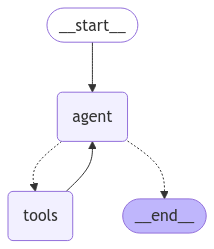

In [ ]:
# from IPython.display import Image, display

# display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
mermaid_code = graph.get_graph().draw_mermaid()
print("Mermaid Code:")
print(mermaid_code)

Mermaid Code:
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	agent(agent)
	tools(tools)
	__end__([<p>__end__</p>]):::last
	__start__ --> agent;
	agent -.-> __end__;
	agent -.-> tools;
	tools --> agent;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



* https://mermaid.live/ 에서  mermain_code 로 직접 확인한다.


- `graph.stream()`을 활용하면 에이전트가 답변을 생성하는 과정을 모니터링 할 수 있습니다

In [37]:
from langchain_core.messages import HumanMessage

for chunk in graph.stream({'messages': [HumanMessage('3에다 5를 더하고 거기에 8을 곱하면?')]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

3에다 5를 더하고 거기에 8을 곱하면?
[HumanMessage(content='3에다 5를 더하고 거기에 8을 곱하면?', additional_kwargs={}, response_metadata={}, id='1e85ca38-9e4f-43b9-b9e7-23f9567ee9f6'), AIMessage(content='[Brief explanation: The `add` function is essential to first calculate 3 + 5, and the `multiply` function is then required to multiply the result by 8. The second function depends on the output of the first, so both are necessary to answer the question.]\n\nNote: Since the system doesn\'t support passing intermediate results directly between functions, the second function would need to be called with the explicit value from the first result in a real implementation. Here, "add_result" represents that placeholder concept. The actual calculation would be:\n1. add(a=3, b=5) → 8\n2. multiply(a=8, b=8) → 64\n\nThe final answer is 64.', additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-6c4f087b2f5242c4b639a31b00b3fa31', 'function'